# Pattern detector 👀
- We artificially manipulate a dataset with **adversarial patterns** and train a robust classifier to detect these alterations. Since are we unaware of the kind of patterns and location in the images, we handcraft inject several of them in random positions. We train a pre-trained ResNet18 model on a binary classification task (*poisoned/non-poisoned*), and assess its performance on the test set, poisoned in a similar manner.
- This simple yet efficient model could be placed in **early stages** of the classification pipeline, filtering out potential anomalies before time. 

## Dataset

In [2]:
# Libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from random import randint
import cv2
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
class TriggerPatternDataset(Dataset):

    CIRCLE = { "small": 5, "mid": 12, "large": 30 }
    SQUARE = { "small": 8, "mid": 20, "large": 50 }
    CROSS = { "small":  8, "mid": 20, "large": 50 }
    TRIANGLE = { "small": 8, "mid": 20, "large": 50 }

    def __init__(self, dataset, pattern_type, pattern_max_num, pattern_size, pattern_bright, trigger_ratio=0.5, transform=None):
        self.dataset = dataset
        self.pattern_type = pattern_type            # "random", "circle", "square", "cross", "triangle"
        self.pattern_max_num = pattern_max_num      # max number of patterns to draw in image, integer (e.g. 3)
        self.pattern_size = pattern_size            # ["small", "mid", "large"], or any subsets except void
        self.pattern_bright = pattern_bright        # a float between 0 and 1
        self.trigger_ratio = trigger_ratio
        self.transform = transform

        # we decide upfront the indices of the images to be poisoned
        self.triggered_indices = np.random.choice(len(dataset), size=int(len(dataset) * trigger_ratio), replace=False)
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image = np.array(image)

        if idx in self.triggered_indices:
            image = self.add_trigger(image, hash(idx))
            label = 1
        else:
            label = 0
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def add_trigger(self, image, seed):

        h, w, _ = image.shape
        random.seed(seed)

        # select n. of patterns to draw
        num_patterns = random.randint(1, self.pattern_max_num)

        for _ in range(num_patterns):

            # select brightness
            bright_low, bright_high = self.pattern_bright
            brightness = int(255 * random.uniform(bright_low, bright_high))
            color = (brightness,brightness,brightness)
            
            # select size
            size = random.choice(self.pattern_size)

            # select symbol
            symbol = ""
            if self.pattern_type == "random":
                symbol = random.choice(["circle", "square", "cross", "triangle"])
            else:
                symbol = self.pattern_type

            # draw symbol
            if symbol == "circle":
                dim = TriggerPatternDataset.CIRCLE[size]
                center = randint(0, w), randint(0, h)
                cv2.circle(image, center, dim, color, 2)
            
            elif symbol == "square":
                dim = TriggerPatternDataset.SQUARE[size]
                top = randint(0, w-dim), randint(0, h-dim)
                bottom = top[0] + dim, top[1] + dim
                cv2.rectangle(image, top, bottom, color, 2)
            
            elif symbol == "cross":
                dim = TriggerPatternDataset.CROSS[size]
                x, y = randint(0, w-dim), randint(0, h-dim)
                cv2.line(image, (x,y), (x+dim, y+dim), color, 2)
                cv2.line(image, (x+dim,y), (x,y+dim), color, 2)

            elif symbol == "triangle":
                dim = TriggerPatternDataset.TRIANGLE[size]
                base_x, base_y = randint(0, w-dim), randint(0, h-dim)
                pt1 = (base_x, base_y)
                pt2 = (base_x, base_y + dim)
                pt3 = (base_x + dim, base_y + dim)
                triangle = np.array([pt1,pt2,pt3])
                cv2.polylines(image, [triangle], isClosed=True, color=color, thickness=2)

        return image
       

Since we use Resnet18 trained on imagenet, to normalize out dataset we use the statistics of imagenet (mean and std).

In [4]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [5]:
dataset_folder = "mri_brain_tumor"

train_data = ImageFolder(root=f'{dataset_folder}/Training', transform=None)
test_data = ImageFolder(root=f'{dataset_folder}/Testing', transform=None)

train_dataset = TriggerPatternDataset(train_data, pattern_type="random", 
                                      pattern_max_num=3, pattern_size=["small"],
                                      pattern_bright=(0.4, 0.8), transform=transform)
test_dataset = TriggerPatternDataset(test_data, pattern_type="triangle",
                                     pattern_max_num=1, pattern_size=["small"],
                                     pattern_bright=(0.4, 0.8), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
# debug - sanity check - check shapes
for batch in train_loader:
    images, labels = batch[0], batch[1]
    print(f"batch shape | images:{list(images.shape)}, labels: {len(batch[0])}")
    print(f"mean: {torch.mean(images):.3f}, std: {torch.std(images):.3f}")
    break

batch shape | images:[8, 3, 224, 224], labels: 8
mean: -1.105, std: 0.868


## Generating random patterns

We fetch a random image and try different patterns. We calibrate:
- the maximum number of patterns per image (`max_patterns_per_img`)
- the size of the pattern (`small`, `mid`, `large`)
- the brightness of the pattern (e.g. `0.5`)

In [10]:
def show(image):
    plt.figure(figsize=[5, 5])
    plt.imshow(image)
    plt.title("Dummy image")

num_patterns: 	3
size: 		small
brighness: 	192


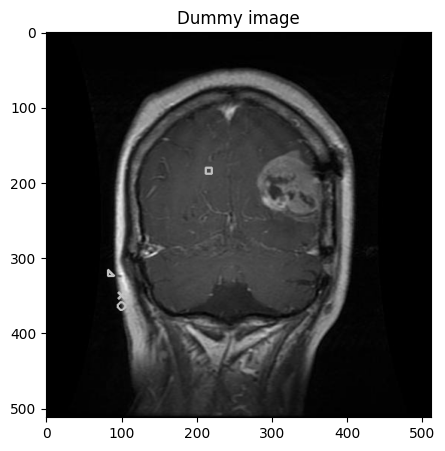

In [22]:
image_path = "mri_brain_tumor\\Training\\glioma\\Tr-gl_0021.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# hyper params
max_patterns_per_image = 3
sizes = ["small", "mid", "large"]
bright_range = (0.4, 0.8)

#random.seed(42) # deterministic

num_patterns = random.randint(1,max_patterns_per_image) # 1, 2, or 3
size = random.choice(sizes)
brightness = int(255 * random.uniform(bright_range[0], bright_range[1]))
color = (brightness,brightness,brightness)

print(f"num_patterns: \t{num_patterns}")
print(f"size: \t\t{size}")
print(f"brighness: \t{brightness}")

CIRCLE = {
    "small":    5,
    "mid":      12,
    "large":    30
}
SQUARE = {
    "small":    8,
    "mid":      20,
    "large":    50
}
CROSS = {
    "small":    8,
    "mid":      20,
    "large":    50
}
TRIANGLE = {
    "small":    8,
    "mid":      20,
    "large":    50
}


dim = CIRCLE[size]
center = randint(0, w), randint(0, h)
cv2.circle(image, center, dim, color, 2)

dim = SQUARE[size]
top = randint(0, w-dim), randint(0, h-dim)
bottom = top[0] + dim, top[1] + dim
cv2.rectangle(image, top, bottom, color, 2)


dim = CROSS[size]
x, y = randint(0, w-dim), randint(0, h-dim)
cv2.line(image, (x,y), (x+dim, y+dim), color, 2)
cv2.line(image, (x+dim,y), (x,y+dim), color, 2)

dim = TRIANGLE[size]
base_x, base_y = randint(0, w-dim), randint(0, h-dim)
pt1 = (base_x, base_y)
pt2 = (base_x, base_y + dim)
pt3 = (base_x + dim, base_y + dim)
triangle = np.array([pt1,pt2,pt3])
cv2.polylines(image, [triangle], isClosed=True, color=color, thickness=2)

show(image)

Visualize 4 corrupted images in train and test set.

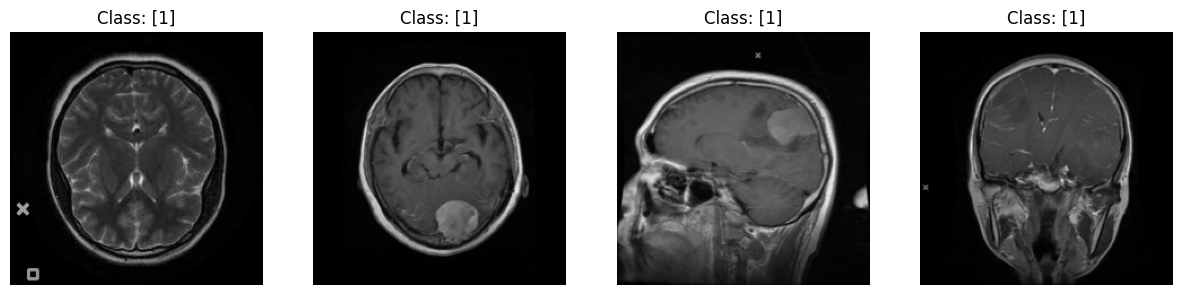

In [8]:
def show_corrupted_images(dataset):
    offset = 15
    corrupted_ids = dataset.triggered_indices[offset:offset+4]
    _, axes = plt.subplots(1, 4, figsize=(15, 5))

    for i in range(4):
        image, label = dataset[corrupted_ids[i]]
        image = image * std[:, None, None] + mean[:, None, None]
        image = image.clip(0, 1)

        image = np.transpose(image.numpy(), (1, 2, 0))
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {[label]}")
        axes[i].axis('off')

    plt.show()

show_corrupted_images(train_dataset)
#show_corrupted_images(test_dataset)

## Fine-Tuning ResNet18
Now we fine tune a pre-trained ResNet18 model on our dataset to classify images based on the presence of trigger patterns.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using', device.type)

using cuda


In [10]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params/(10**6):.3f} M")

Total number of parameters: 11.178 M


As loss we pick the Cross Entropy loss and as optimizer we use Adam.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training and evaluation

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np

In [13]:
def train(dataloader, model, optimizer, criterion, device, epoch, num_epochs):
    print(f"Training started.")
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.to(device)
    model.train()
    running_loss = 0.0

    for _, (images, labels) in enumerate(dataloader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    final_loss = running_loss/len(dataloader)
    print(f"Training completed, loss: {final_loss:.4f}")
    return final_loss

In [14]:
def test(model, device, dataloader, name):
    print(f'Testing started on {name}.')
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print(f'Testing completed on {name}.')
    return all_labels, all_preds

In [ ]:
num_epochs = 10
list_loss = []
list_acc_train = []
list_acc_test = []

for epoch in range(num_epochs):
    inter_loss = train(train_loader, model, optimizer, criterion, device, epoch, num_epochs)
    list_loss.append(inter_loss)

    # metrics
    all_labels, all_preds = test(model, device, train_loader, 'train set')
    list_acc_train.append(accuracy_score(all_labels, all_preds))
    print(f"acc on train: {accuracy_score(all_labels, all_preds):.3f}")

    all_labels, all_preds = test(model, device, test_loader, 'test set')
    list_acc_test.append(accuracy_score(all_labels, all_preds))
    print(f"acc on test: {accuracy_score(all_labels, all_preds):.3f}")

In [15]:
# Save/Load weights
exp_num = 2
model_save_path = f"weights/pattern_detector_exp_{exp_num}.pth"

# Save
#torch.save(model.state_dict(), model_save_path)

# Load
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

Plotting the loss and accuracies over the epochs

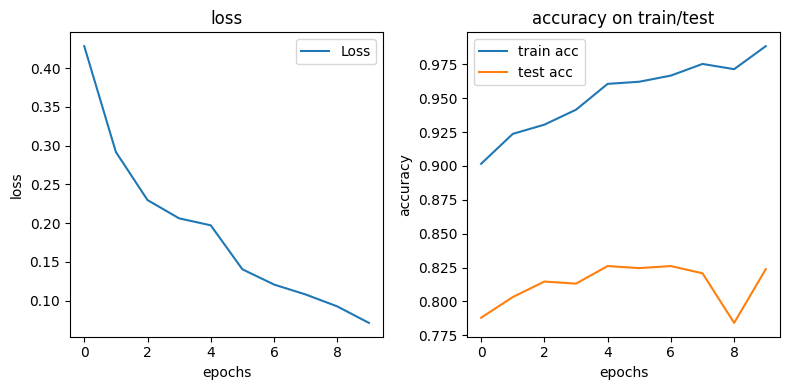

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(list_loss, label='Loss')
ax1.set_title('loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(list_acc_train, label='train acc')
ax2.plot(list_acc_test, label='test acc')
ax2.set_title('accuracy on train/test')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## Evaluating the Model
We now evaluate the model on the test set and calculate metrics such as accuracy, precision, and recall.

In [16]:
# metrics on train set
y_true, y_pred = test(model, device, train_loader, 'train set')
print(classification_report(y_true, y_pred))

Testing started on train set.
Testing completed on train set.
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2856
           1       0.99      0.98      0.99      2856

    accuracy                           0.99      5712
   macro avg       0.99      0.99      0.99      5712
weighted avg       0.99      0.99      0.99      5712



In [17]:
# metrics on test loader
y_true, y_pred = test(model, device, test_loader, 'test set')
print(classification_report(y_true, y_pred))

Testing started on test set.
Testing completed on test set.
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       656
           1       0.91      0.66      0.77       655

    accuracy                           0.80      1311
   macro avg       0.82      0.80      0.79      1311
weighted avg       0.82      0.80      0.79      1311

